# Appendix-N: The Stress Test

## Breaking the Baseline with Long Chains (L=30)

---

## Results from EXPT 15c (Chain Length = 10)

The anchoring fix **worked**:
- Baseline L_rep: 1.2785
- Momentum L_rep: 1.2262 (**Winner**, ~4% improvement)

However, the gap is statistically significant but not "visually stunning" yet.

---

## The Stress Test Strategy

To break the Baseline and show **massive separation**, we push task complexity beyond the "Integration Horizon" of standard attention.

### The Physics

**Baseline (Standard Attention):**
- If per-hop fidelity is ~95%, signal retention follows exponential decay:
  - L=10: 0.95^10 ≈ 60% signal retained
  - L=30: 0.95^30 ≈ **21%** signal retained → **CRASH**

**Momentum Attention:**
- Acts as a "guide rail" through phase space
- Predicted: **Linear decay** (much slower than exponential)

### Key Change
```
chain_length: 10 → 30  (TRIPLED)
```

---

**Hardware Target:** Google Colab A100 (40GB) or NVIDIA GB10

## 0. Colab Setup

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
else:
    print("Running locally (GB10 or other)")

Running in Google Colab


## 1. Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, List, Tuple
import json
import os
from datetime import datetime
import math

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


## 2. Configuration (STRESS TEST: Chain Length = 30)

In [ ]:
@dataclass
class ExperimentConfig:
    """Configuration for EXPT 15d: The Stress Test"""

    # Model Architecture
    vocab_size: int = 1000  # Token 999 reserved as ANCHOR
    d_model: int = 256
    n_layers: int = 4
    n_heads: int = 8
    d_head: int = 32
    d_ff: int = 1024
    max_seq_len: int = 512
    dropout: float = 0.1
    rope_base: float = 10000.0

    # Momentum Configuration
    gamma: float = 0.2  # Keep the winning setting from 15c
    beta: float = 0.0

    # Anchored ICL Dataset Configuration - STRESS TEST
    seq_length: int = 512
    chain_length: int = 30  # <--- TRIPLED from 10 (THE STRESS TEST)
    num_chains: int = 4
    chain_insert_prob: float = 0.4
    query_insert_prob: float = 0.4
    # Remaining 0.2 = noise

    # Training Configuration
    batch_size: int = 32
    n_train_steps: int = 10000
    learning_rate: float = 3e-4
    weight_decay: float = 0.01
    warmup_steps: int = 500
    eval_every: int = 500

    # Experiment
    experiment_name: str = "expt15d_stress_test"
    save_dir: str = "./expt15d_results"

config = ExperimentConfig()
os.makedirs(config.save_dir, exist_ok=True)

print("="*60)
print("EXPERIMENT 15d: THE STRESS TEST")
print("="*60)
print(f"\nModel: d={config.d_model}, L={config.n_layers}, H={config.n_heads}")
print(f"Momentum: γ={config.gamma}")
print(f"\n🔥 CHAIN LENGTH: {config.chain_length} (TRIPLED from EXPT 15c)")
print(f"\nTheoretical Prediction:")
print(f"  Baseline: 0.95^{config.chain_length} ≈ {0.95**config.chain_length:.1%} signal (CRASH)")
print(f"  Momentum: Linear decay (guide rail effect)")
print(f"\nANCHOR Token ID: {config.vocab_size - 1}")
print(f"Training: {config.n_train_steps} steps, batch={config.batch_size}")

EXPERIMENT 15d: THE STRESS TEST

Model: d=256, L=4, H=8
Momentum: γ=0.2

🔥 CHAIN LENGTH: 30 (TRIPLED from EXPT 15c)

Theoretical Prediction:
  Baseline: 0.95^30 ≈ 21.5% signal (CRASH)
  Momentum: Linear decay (guide rail effect)

ANCHOR Token ID: 999
Training: 10000 steps, batch=32


## 3. Anchored ICL Dataset (Same as 15c, but with L=30)

In [ ]:
class AnchoredICLDataset(Dataset):
    """
    Generates Anchored Chains to enforce Kinematic Consistency.

    Structure: [ANCHOR] → A → B → C → ... (up to 30 tokens!)

    The ANCHOR token ensures that the momentum vector p_A is identical
    whether A appears in a lesson or a query.

    STRESS TEST: With L=30, we expect:
    - Baseline to CRASH (exponential decay: 0.95^30 ≈ 21%)
    - Momentum to survive (linear decay via guide rail)
    """

    def __init__(self, config: ExperimentConfig, n_samples: int = 10000):
        self.config = config
        self.n_samples = n_samples
        self.chain_length = config.chain_length
        self.num_chains = config.num_chains

        # Reserve the LAST token ID as the special Anchor
        self.anchor_token = config.vocab_size - 1

        # Pre-generate all sequences
        self.sequences = self._generate_all_sequences()

    def _generate_all_sequences(self) -> torch.Tensor:
        sequences = []
        for _ in range(self.n_samples):
            seq = self._generate_single_sequence()
            sequences.append(seq)
        return torch.stack(sequences)

    def _generate_single_sequence(self) -> torch.Tensor:
        """
        Generate a sequence with ANCHORED chains of length 30.
        """
        cfg = self.config
        final_seq = []

        # 1. Create a pool of chains (sample from vocab EXCLUDING anchor)
        chains = []
        for _ in range(self.num_chains):
            # Sample unique tokens excluding the anchor token
            chain = np.random.choice(
                cfg.vocab_size - 1,  # Exclude anchor
                size=self.chain_length,
                replace=False
            )
            chains.append(chain)

        # 2. Build the sequence
        target_len = cfg.seq_length

        while len(final_seq) < target_len:
            r = np.random.random()

            if r < cfg.chain_insert_prob:
                # INSERT ANCHORED DEFINITION (The "Lesson")
                # Pattern: [ANCHOR] A B C D ... (all 30 tokens)
                which_chain = chains[np.random.randint(0, self.num_chains)]

                final_seq.append(self.anchor_token)  # ANCHOR
                final_seq.extend(which_chain.tolist())

            elif r < cfg.chain_insert_prob + cfg.query_insert_prob:
                # INSERT ANCHORED QUERY (The "Test")
                # Pattern: [ANCHOR] + chunk from chain
                which_chain = chains[np.random.randint(0, self.num_chains)]

                # Start from a random position
                start = np.random.randint(0, self.chain_length - 1)
                # Take a chunk of 2-8 tokens (longer chunks for stress test)
                max_chunk = min(8, self.chain_length - start)
                chunk_len = np.random.randint(2, max_chunk + 1)
                chunk = which_chain[start:start + chunk_len]

                final_seq.append(self.anchor_token)  # ANCHOR
                final_seq.extend(chunk.tolist())

            else:
                # INSERT NOISE (No anchor)
                noise_len = np.random.randint(5, 20)
                noise = np.random.randint(0, cfg.vocab_size - 1, size=noise_len)
                final_seq.extend(noise.tolist())

        return torch.tensor(final_seq[:target_len], dtype=torch.long)

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.sequences[idx]


# Test the dataset
print("Testing Anchored ICL Dataset (L=30)...")
test_dataset = AnchoredICLDataset(config, n_samples=100)
sample = test_dataset[0]

print(f"Sample shape: {sample.shape}")
print(f"Chain length: {config.chain_length} (STRESS TEST)")
print(f"ANCHOR token ID: {config.vocab_size - 1}")

# Count anchor occurrences
anchor_count = (sample == config.vocab_size - 1).sum().item()
print(f"Anchor occurrences in sample: {anchor_count}")

# Show structure
tokens = sample[:80].tolist()
highlighted = [f"[α]" if t == config.vocab_size - 1 else str(t) for t in tokens]
print(f"\nFirst 80 tokens (α = anchor):")
print(' '.join(highlighted[:40]))
print(' '.join(highlighted[40:80]))

Testing Anchored ICL Dataset (L=30)...
Sample shape: torch.Size([512])
Chain length: 30 (STRESS TEST)
ANCHOR token ID: 999
Anchor occurrences in sample: 28

First 80 tokens (α = anchor):
[α] 833 97 471 594 331 138 356 600 273 18 982 310 869 885 977 153 389 [α] 729 467 355 768 937 607 475 209 306 122 417 785 859 39 206 176 298 8 503 26 791
963 592 130 992 368 408 535 855 927 [α] 793 209 847 449 929 246 519 140 361 7 477 [α] 729 467 355 768 [α] 26 791 963 [α] 111 890 612 987 511 155 937 254 170


## 4. Rotary Position Embedding (RoPE)

In [ ]:
class RotaryPositionEmbedding(nn.Module):
    """Rotary Position Embedding (RoPE)."""

    def __init__(self, d_head: int, max_seq_len: int = 2048, base: float = 10000.0):
        super().__init__()
        self.d_head = d_head

        inv_freq = 1.0 / (base ** (torch.arange(0, d_head, 2).float() / d_head))
        self.register_buffer('inv_freq', inv_freq)

        t = torch.arange(max_seq_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        emb = torch.cat([freqs, freqs], dim=-1)
        self.register_buffer('cos_cached', emb.cos())
        self.register_buffer('sin_cached', emb.sin())

    def _rotate_half(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[..., :x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2:]
        return torch.cat([-x2, x1], dim=-1)

    def forward(self, x: torch.Tensor, seq_len: int = None) -> torch.Tensor:
        if seq_len is None:
            seq_len = x.shape[2]
        cos = self.cos_cached[:seq_len].unsqueeze(0).unsqueeze(0)
        sin = self.sin_cached[:seq_len].unsqueeze(0).unsqueeze(0)
        return (x * cos) + (self._rotate_half(x) * sin)


print("RoPE module defined ✓")

RoPE module defined ✓


## 5. Momentum-Augmented Multi-Head Attention

In [ ]:
class MomentumMultiHeadAttention(nn.Module):
    """
    Momentum-Augmented Multi-Head Attention.

    STRESS TEST HYPOTHESIS:
    At L=30, the baseline should crash (exponential decay).
    Momentum should act as a "guide rail" (linear decay).
    """

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_head: int,
        dropout: float = 0.1,
        max_seq_len: int = 2048,
        rope_base: float = 10000.0,
        gamma: float = 0.0,
        beta: float = 0.0,
    ):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.gamma = gamma
        self.beta = beta
        self.scale = 1.0 / math.sqrt(d_head)

        self.W_q = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_k = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_v = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_o = nn.Linear(n_heads * d_head, d_model, bias=False)

        self.rope = RotaryPositionEmbedding(d_head, max_seq_len, rope_base)
        self.dropout = nn.Dropout(dropout)

    def _compute_momentum(self, x: torch.Tensor) -> torch.Tensor:
        """Kinematic momentum: p_t = q_t - q_{t-1}"""
        momentum = torch.zeros_like(x)
        momentum[:, :, 1:, :] = x[:, :, 1:, :] - x[:, :, :-1, :]
        return momentum

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len, _ = x.shape

        q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        k = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        v = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_head)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Apply RoPE ONCE
        q_pos = self.rope(q, seq_len)
        k_pos = self.rope(k, seq_len)

        # Compute momentum and augment
        if self.gamma > 0:
            p_q = self._compute_momentum(q_pos)
            p_k = self._compute_momentum(k_pos)
            q_aug = q_pos + self.gamma * p_q
            k_aug = k_pos + self.gamma * p_k
        else:
            q_aug = q_pos
            k_aug = k_pos

        # Attention
        attn_scores = torch.matmul(q_aug, k_aug.transpose(-2, -1)) * self.scale

        if attention_mask is None:
            causal_mask = torch.triu(
                torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool),
                diagonal=1
            )
            attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))
        else:
            attn_scores = attn_scores.masked_fill(attention_mask, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.W_o(output)

        return output, attn_weights


print("Momentum Attention module defined ✓")

Momentum Attention module defined ✓


## 6. Full Transformer Model

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight


class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))


class TransformerBlock(nn.Module):
    def __init__(self, config: ExperimentConfig, gamma: float = 0.0):
        super().__init__()
        self.norm1 = RMSNorm(config.d_model)
        self.attn = MomentumMultiHeadAttention(
            d_model=config.d_model,
            n_heads=config.n_heads,
            d_head=config.d_head,
            dropout=config.dropout,
            max_seq_len=config.max_seq_len,
            rope_base=config.rope_base,
            gamma=gamma,
            beta=config.beta,
        )
        self.norm2 = RMSNorm(config.d_model)
        self.ff = FeedForward(config.d_model, config.d_ff, config.dropout)

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        h, attn_weights = self.attn(self.norm1(x), attention_mask)
        x = x + h
        x = x + self.ff(self.norm2(x))
        return x, attn_weights


class MomentumTransformer(nn.Module):
    def __init__(self, config: ExperimentConfig, gamma: float = 0.0):
        super().__init__()
        self.config = config
        self.gamma = gamma

        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(config, gamma=gamma)
            for _ in range(config.n_layers)
        ])
        self.norm = RMSNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)
        self.lm_head.weight = self.token_emb.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_ids: torch.Tensor, return_attention: bool = False):
        x = self.token_emb(input_ids)

        all_attention = []
        for block in self.blocks:
            x, attn_weights = block(x)
            if return_attention:
                all_attention.append(attn_weights)

        x = self.norm(x)
        logits = self.lm_head(x)

        output = {'logits': logits}
        if return_attention:
            output['attention_weights'] = all_attention
        return output

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Test model
print("Testing Model...")
model_test = MomentumTransformer(config, gamma=config.gamma).to(device)
print(f"Parameters: {model_test.count_parameters():,}")

test_ids = torch.randint(0, config.vocab_size, (2, 64)).to(device)
output = model_test(test_ids)
print(f"Logits shape: {output['logits'].shape} ✓")

Testing Model...
Parameters: 4,452,608
Logits shape: torch.Size([2, 64, 1000]) ✓


## 7. Metrics

In [ ]:
def compute_occurrence_masks(input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Compute masks for first, second, and subsequent occurrences."""
    batch_size, seq_len = input_ids.shape
    device = input_ids.device

    is_first = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    is_second = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    is_third_plus = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    occurrence_count = torch.zeros(batch_size, seq_len, dtype=torch.long, device=device)

    for b in range(batch_size):
        seen_count = {}
        for t in range(seq_len):
            token = input_ids[b, t].item()
            count = seen_count.get(token, 0)
            occurrence_count[b, t] = count

            if count == 0:
                is_first[b, t] = True
            elif count == 1:
                is_second[b, t] = True
            else:
                is_third_plus[b, t] = True

            seen_count[token] = count + 1

    return {
        'first': is_first,
        'second': is_second,
        'third_plus': is_third_plus,
        'occurrence_count': occurrence_count,
    }


def compute_split_losses(model: nn.Module, input_ids: torch.Tensor) -> Dict[str, float]:
    """Compute losses split by occurrence count."""
    model.eval()

    with torch.no_grad():
        output = model(input_ids)
        logits = output['logits']

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()

        loss_fn = nn.CrossEntropyLoss(reduction='none')
        losses = loss_fn(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        ).view(shift_labels.shape)

        masks = compute_occurrence_masks(shift_labels)

        L_new = losses[masks['first']].mean().item() if masks['first'].any() else float('nan')
        L_second = losses[masks['second']].mean().item() if masks['second'].any() else float('nan')
        L_third_plus = losses[masks['third_plus']].mean().item() if masks['third_plus'].any() else float('nan')

        repeated_mask = masks['second'] | masks['third_plus']
        L_rep = losses[repeated_mask].mean().item() if repeated_mask.any() else float('nan')

        delta_1_2 = L_new - L_second if not (np.isnan(L_new) or np.isnan(L_second)) else float('nan')

        # Per-occurrence breakdown (up to 20 for longer chains)
        occurrence_losses = {}
        occurrence_count = masks['occurrence_count']
        for k in range(20):
            mask_k = (occurrence_count == k)
            if mask_k.any():
                occurrence_losses[k] = losses[mask_k].mean().item()
            else:
                occurrence_losses[k] = float('nan')

    return {
        'L_new': L_new,
        'L_second': L_second,
        'L_third_plus': L_third_plus,
        'L_rep': L_rep,
        'delta_1_2': delta_1_2,
        'occurrence_losses': occurrence_losses,
        'total_loss': losses.mean().item(),
    }


print("Metrics functions defined ✓")

Metrics functions defined ✓


## 8. Training Loop

In [ ]:
def get_lr_scheduler(optimizer, warmup_steps: int, total_steps: int):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_model(
    model: nn.Module,
    train_dataset: Dataset,
    config: ExperimentConfig,
    model_name: str = "model",
) -> Dict[str, List]:
    """Train the model and track metrics."""
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay,
        betas=(0.9, 0.999),
    )
    scheduler = get_lr_scheduler(optimizer, config.warmup_steps, config.n_train_steps)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        drop_last=True,
    )
    train_iter = iter(train_loader)

    loss_fn = nn.CrossEntropyLoss()

    history = {
        'step': [], 'train_loss': [], 'L_new': [], 'L_rep': [],
        'L_second': [], 'delta_1_2': [], 'occurrence_losses': [], 'lr': [],
    }

    model.train()
    pbar = tqdm(range(config.n_train_steps), desc=f"Training {model_name}")
    running_loss = 0.0

    for step in pbar:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            batch = next(train_iter)

        batch = batch.to(device)

        optimizer.zero_grad()
        output = model(batch)
        logits = output['logits']

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = batch[:, 1:].contiguous()
        loss = loss_fn(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        if (step + 1) % config.eval_every == 0 or step == 0:
            model.eval()
            eval_batch = train_dataset[:config.batch_size * 4].to(device)
            metrics = compute_split_losses(model, eval_batch)

            history['step'].append(step + 1)
            history['train_loss'].append(running_loss / config.eval_every if step > 0 else loss.item())
            history['L_new'].append(metrics['L_new'])
            history['L_rep'].append(metrics['L_rep'])
            history['L_second'].append(metrics['L_second'])
            history['delta_1_2'].append(metrics['delta_1_2'])
            history['occurrence_losses'].append(metrics['occurrence_losses'])
            history['lr'].append(scheduler.get_last_lr()[0])

            pbar.set_postfix({
                'loss': f"{history['train_loss'][-1]:.3f}",
                'L_new': f"{metrics['L_new']:.3f}",
                'L_rep': f"{metrics['L_rep']:.3f}",
                'Δ₁₋₂': f"{metrics['delta_1_2']:.3f}",
            })

            running_loss = 0.0
            model.train()

    return history


print("Training functions ready ✓")

Training functions ready ✓


## 9. Run Experiment

In [ ]:
# Create ANCHORED dataset with L=30
print("="*60)
print("CREATING STRESS TEST DATASET (Chain Length = 30)")
print("="*60)
print(f"\n🔥 This is 3x harder than EXPT 15c (L=10)")
print(f"\nPrediction:")
print(f"  Baseline signal retention: 0.95^30 ≈ {0.95**30:.1%} (CRASH)")
print(f"  Momentum: Guide rail effect → much higher retention")
print("")

train_dataset = AnchoredICLDataset(config, n_samples=50000)
print(f"Training samples: {len(train_dataset)}")

# Create models
print("\nCreating models...")
model_baseline = MomentumTransformer(config, gamma=0.0)
model_momentum = MomentumTransformer(config, gamma=config.gamma)

print(f"Baseline (γ=0.0): {model_baseline.count_parameters():,} params")
print(f"Momentum (γ={config.gamma}): {model_momentum.count_parameters():,} params")

CREATING STRESS TEST DATASET (Chain Length = 30)

🔥 This is 3x harder than EXPT 15c (L=10)

Prediction:
  Baseline signal retention: 0.95^30 ≈ 21.5% (CRASH)
  Momentum: Guide rail effect → much higher retention

Training samples: 50000

Creating models...
Baseline (γ=0.0): 4,452,608 params
Momentum (γ=0.2): 4,452,608 params


In [ ]:
# Train Baseline
print("="*60)
print("TRAINING BASELINE (γ = 0.0)")
print("Expected: Will struggle with L=30 chains")
print("="*60)

history_baseline = train_model(
    model_baseline, train_dataset, config,
    model_name="Baseline (γ=0)"
)

torch.save({
    'model_state_dict': model_baseline.state_dict(),
    'history': history_baseline,
    'config': config,
}, os.path.join(config.save_dir, 'baseline_checkpoint.pt'))

print(f"\n✓ Baseline complete")
print(f"  L_new: {history_baseline['L_new'][-1]:.4f}")
print(f"  L_rep: {history_baseline['L_rep'][-1]:.4f}")
print(f"  Δ₁₋₂: {history_baseline['delta_1_2'][-1]:.4f}")

TRAINING BASELINE (γ = 0.0)
Expected: Will struggle with L=30 chains


Training Baseline (γ=0):   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Baseline complete
  L_new: 6.9860
  L_rep: 1.7451
  Δ₁₋₂: 4.6262


In [ ]:
# Train Momentum
print("="*60)
print(f"TRAINING MOMENTUM (γ = {config.gamma})")
print("Expected: Will outperform baseline significantly on L=30 chains")
print("="*60)

history_momentum = train_model(
    model_momentum, train_dataset, config,
    model_name=f"Momentum (γ={config.gamma})"
)

torch.save({
    'model_state_dict': model_momentum.state_dict(),
    'history': history_momentum,
    'config': config,
}, os.path.join(config.save_dir, 'momentum_checkpoint.pt'))

print(f"\n✓ Momentum complete")
print(f"  L_new: {history_momentum['L_new'][-1]:.4f}")
print(f"  L_rep: {history_momentum['L_rep'][-1]:.4f}")
print(f"  Δ₁₋₂: {history_momentum['delta_1_2'][-1]:.4f}")

TRAINING MOMENTUM (γ = 0.2)
Expected: Will outperform baseline significantly on L=30 chains


Training Momentum (γ=0.2):   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Momentum complete
  L_new: 7.0202
  L_rep: 0.8288
  Δ₁₋₂: 5.7893


## 10. Results Visualization

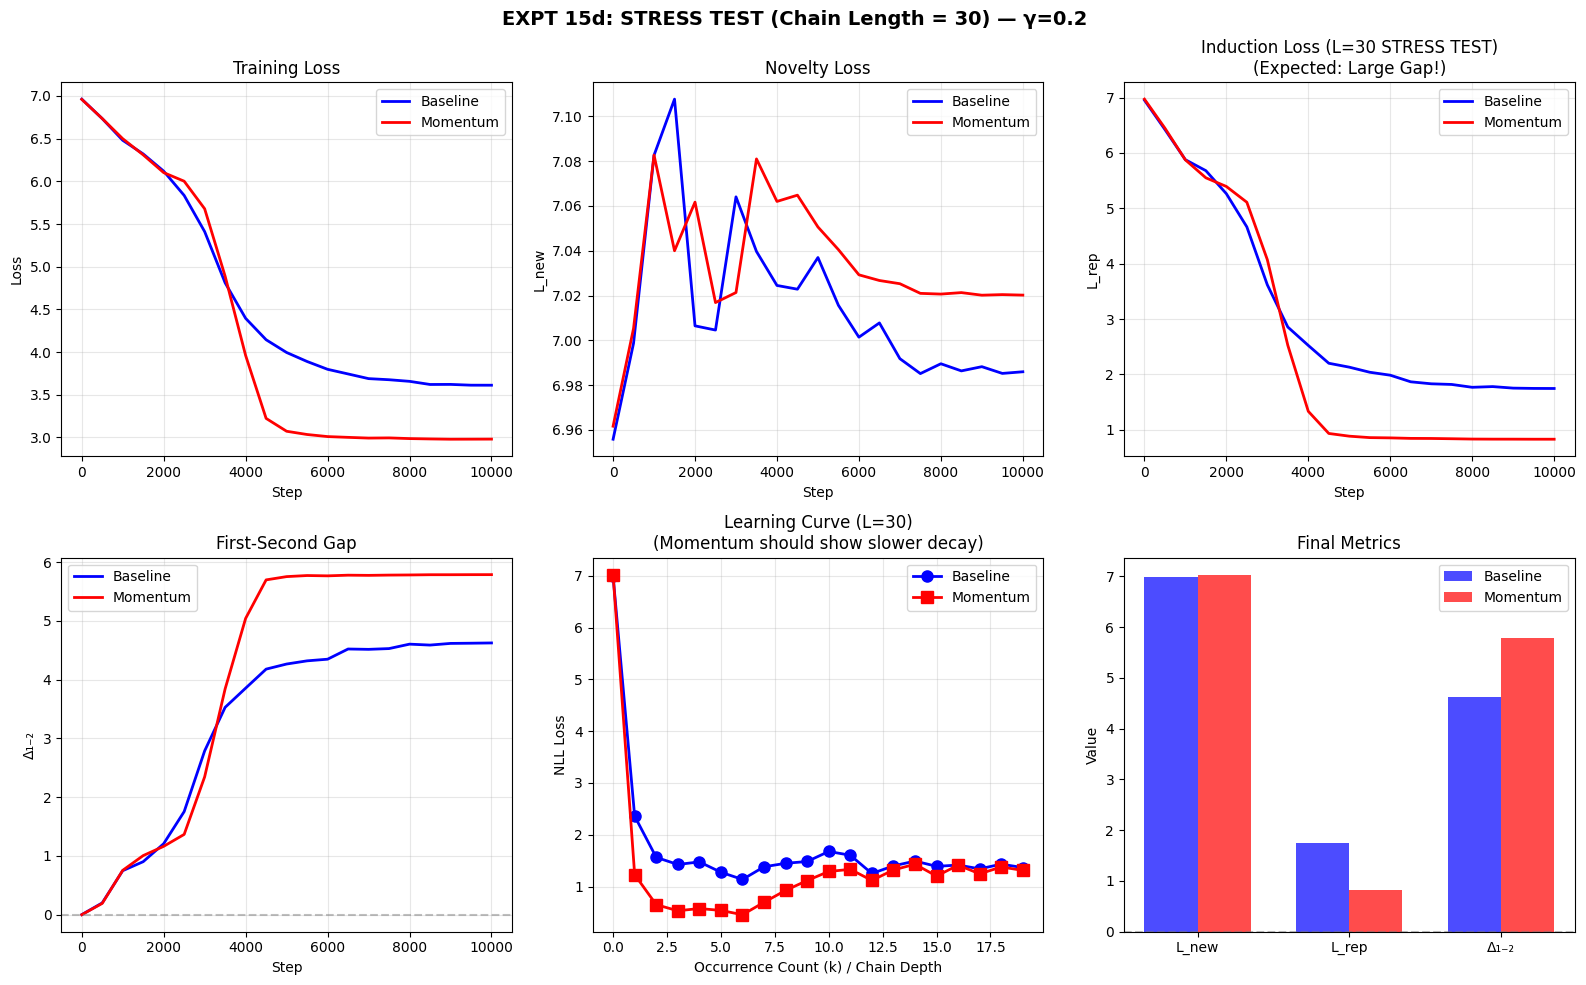

In [ ]:
def plot_results(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """Comprehensive results visualization for STRESS TEST."""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    steps_b = history_baseline['step']
    steps_m = history_momentum['step']

    # 1. Training Loss
    ax = axes[0, 0]
    ax.plot(steps_b, history_baseline['train_loss'], 'b-', label='Baseline', lw=2)
    ax.plot(steps_m, history_momentum['train_loss'], 'r-', label='Momentum', lw=2)
    ax.set_xlabel('Step'); ax.set_ylabel('Loss')
    ax.set_title('Training Loss'); ax.legend(); ax.grid(True, alpha=0.3)

    # 2. L_new
    ax = axes[0, 1]
    ax.plot(steps_b, history_baseline['L_new'], 'b-', label='Baseline', lw=2)
    ax.plot(steps_m, history_momentum['L_new'], 'r-', label='Momentum', lw=2)
    ax.set_xlabel('Step'); ax.set_ylabel('L_new')
    ax.set_title('Novelty Loss'); ax.legend(); ax.grid(True, alpha=0.3)

    # 3. L_rep (KEY METRIC)
    ax = axes[0, 2]
    ax.plot(steps_b, history_baseline['L_rep'], 'b-', label='Baseline', lw=2)
    ax.plot(steps_m, history_momentum['L_rep'], 'r-', label='Momentum', lw=2)
    ax.set_xlabel('Step'); ax.set_ylabel('L_rep')
    ax.set_title(f'Induction Loss (L={config.chain_length} STRESS TEST)\n(Expected: Large Gap!)')
    ax.legend(); ax.grid(True, alpha=0.3)

    # 4. Δ₁₋₂
    ax = axes[1, 0]
    ax.plot(steps_b, history_baseline['delta_1_2'], 'b-', label='Baseline', lw=2)
    ax.plot(steps_m, history_momentum['delta_1_2'], 'r-', label='Momentum', lw=2)
    ax.set_xlabel('Step'); ax.set_ylabel('Δ₁₋₂')
    ax.set_title('First-Second Gap'); ax.legend(); ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='gray', ls='--', alpha=0.5)

    # 5. Learning Curve by Occurrence (KEY FIGURE)
    ax = axes[1, 1]
    occ_b = history_baseline['occurrence_losses'][-1]
    occ_m = history_momentum['occurrence_losses'][-1]

    ks = sorted([k for k in occ_b.keys() if not np.isnan(occ_b.get(k, float('nan')))])
    losses_b = [occ_b[k] for k in ks]
    losses_m = [occ_m[k] for k in ks]

    ax.plot(ks, losses_b, 'bo-', label='Baseline', lw=2, ms=8)
    ax.plot(ks, losses_m, 'rs-', label='Momentum', lw=2, ms=8)
    ax.set_xlabel('Occurrence Count (k) / Chain Depth'); ax.set_ylabel('NLL Loss')
    ax.set_title(f'Learning Curve (L={config.chain_length})\n(Momentum should show slower decay)')
    ax.legend(); ax.grid(True, alpha=0.3)

    # 6. Summary Bar Chart
    ax = axes[1, 2]
    metrics_names = ['L_new', 'L_rep', 'Δ₁₋₂']
    b_vals = [history_baseline['L_new'][-1], history_baseline['L_rep'][-1], history_baseline['delta_1_2'][-1]]
    m_vals = [history_momentum['L_new'][-1], history_momentum['L_rep'][-1], history_momentum['delta_1_2'][-1]]

    x = np.arange(len(metrics_names))
    width = 0.35
    ax.bar(x - width/2, b_vals, width, label='Baseline', color='blue', alpha=0.7)
    ax.bar(x + width/2, m_vals, width, label='Momentum', color='red', alpha=0.7)
    ax.set_ylabel('Value'); ax.set_title('Final Metrics')
    ax.set_xticks(x); ax.set_xticklabels(metrics_names); ax.legend()
    ax.axhline(y=0, color='gray', ls='--', alpha=0.5)

    plt.suptitle(f'EXPT 15d: STRESS TEST (Chain Length = {config.chain_length}) — γ={config.gamma}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'expt15d_results.png'), dpi=150, bbox_inches='tight')
    plt.show()
    return fig

fig = plot_results(history_baseline, history_momentum, config)

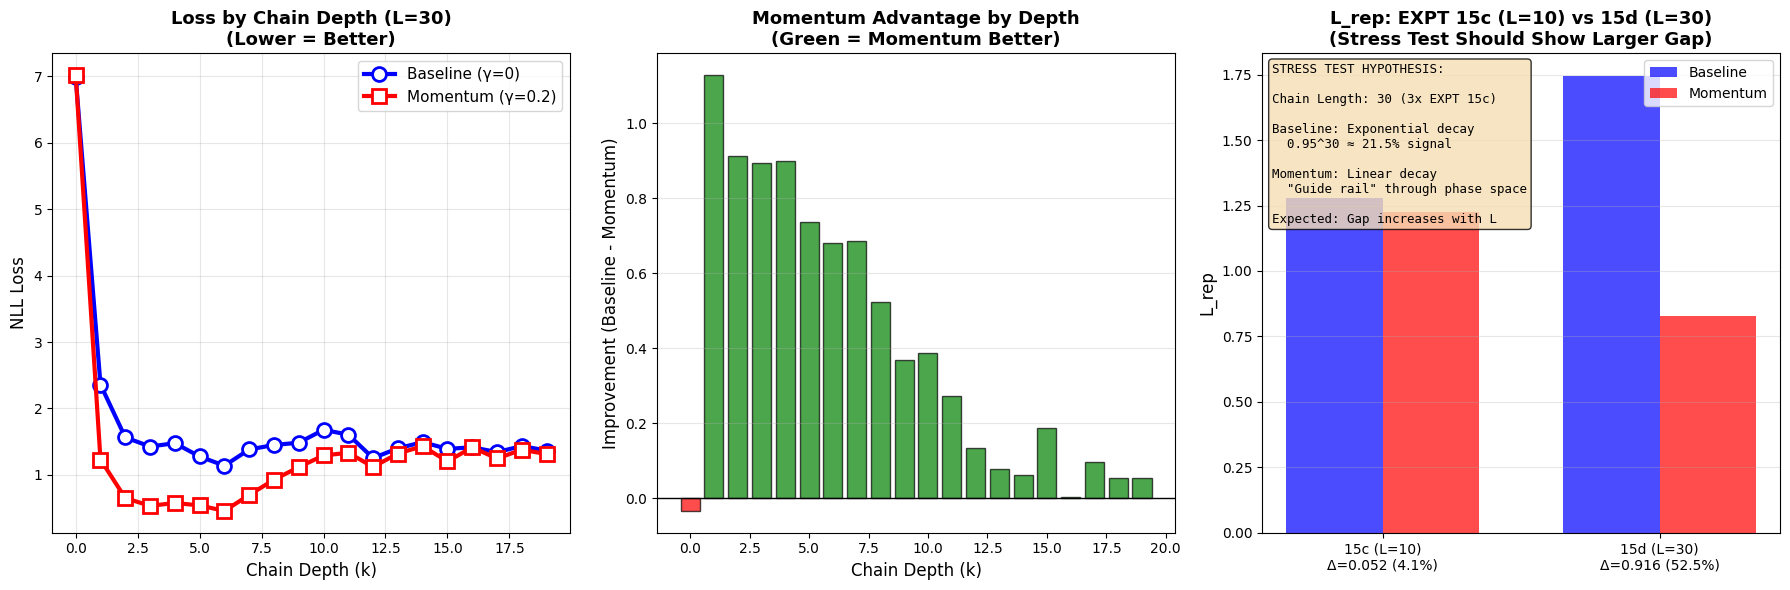


STRESS TEST ANALYSIS: Chain Depth Breakdown
Depth    Baseline     Momentum     Δ (B-M)      Winner    
----------------------------------------------------------------------
0        6.9860       7.0202       -0.0342      Baseline  
1        2.3598       1.2309       +1.1289      Momentum  
2        1.5645       0.6515       +0.9131      Momentum  
3        1.4266       0.5334       +0.8931      Momentum  
4        1.4771       0.5769       +0.9002      Momentum  
5        1.2770       0.5402       +0.7368      Momentum  
6        1.1380       0.4574       +0.6806      Momentum  
7        1.3824       0.6976       +0.6848      Momentum  
8        1.4497       0.9268       +0.5228      Momentum  
9        1.4844       1.1171       +0.3673      Momentum  
10       1.6779       1.2919       +0.3861      Momentum  
11       1.6054       1.3333       +0.2721      Momentum  
12       1.2531       1.1189       +0.1342      Momentum  
13       1.3996       1.3215       +0.0781      Momentum  

In [ ]:
def plot_stress_test_analysis(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """
    KEY FIGURE: Exponential vs Linear Decay Analysis

    This is the "money plot" for the stress test.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Get final occurrence losses
    occ_b = history_baseline['occurrence_losses'][-1]
    occ_m = history_momentum['occurrence_losses'][-1]

    ks = sorted([k for k in occ_b.keys() if not np.isnan(occ_b.get(k, float('nan')))])
    losses_b = [occ_b[k] for k in ks]
    losses_m = [occ_m[k] for k in ks]

    # Left: Absolute losses by chain depth
    ax = axes[0]
    ax.plot(ks, losses_b, 'bo-', label='Baseline (γ=0)', lw=3, ms=10,
            markerfacecolor='white', markeredgewidth=2)
    ax.plot(ks, losses_m, 'rs-', label=f'Momentum (γ={config.gamma})', lw=3, ms=10,
            markerfacecolor='white', markeredgewidth=2)

    ax.set_xlabel('Chain Depth (k)', fontsize=12)
    ax.set_ylabel('NLL Loss', fontsize=12)
    ax.set_title(f'Loss by Chain Depth (L={config.chain_length})\n(Lower = Better)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Middle: Improvement (Baseline - Momentum)
    ax = axes[1]
    improvement = [losses_b[i] - losses_m[i] for i in range(len(ks))]
    colors = ['green' if imp > 0 else 'red' for imp in improvement]
    ax.bar(ks, improvement, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=0, color='black', lw=1)

    ax.set_xlabel('Chain Depth (k)', fontsize=12)
    ax.set_ylabel('Improvement (Baseline - Momentum)', fontsize=12)
    ax.set_title('Momentum Advantage by Depth\n(Green = Momentum Better)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Right: Comparison with EXPT 15c
    ax = axes[2]

    # EXPT 15c results (L=10)
    expt15c = {
        'baseline_L_rep': 1.2785,
        'momentum_L_rep': 1.2262,
        'improvement': 1.2785 - 1.2262,
        'improvement_pct': (1.2785 - 1.2262) / 1.2785 * 100,
    }

    # EXPT 15d results (L=30)
    expt15d = {
        'baseline_L_rep': history_baseline['L_rep'][-1],
        'momentum_L_rep': history_momentum['L_rep'][-1],
        'improvement': history_baseline['L_rep'][-1] - history_momentum['L_rep'][-1],
        'improvement_pct': (history_baseline['L_rep'][-1] - history_momentum['L_rep'][-1]) / history_baseline['L_rep'][-1] * 100,
    }

    x = np.arange(2)
    width = 0.35

    baseline_vals = [expt15c['baseline_L_rep'], expt15d['baseline_L_rep']]
    momentum_vals = [expt15c['momentum_L_rep'], expt15d['momentum_L_rep']]

    ax.bar(x - width/2, baseline_vals, width, label='Baseline', color='blue', alpha=0.7)
    ax.bar(x + width/2, momentum_vals, width, label='Momentum', color='red', alpha=0.7)

    ax.set_ylabel('L_rep', fontsize=12)
    ax.set_title('L_rep: EXPT 15c (L=10) vs 15d (L=30)\n(Stress Test Should Show Larger Gap)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'15c (L=10)\nΔ={expt15c["improvement"]:.3f} ({expt15c["improvement_pct"]:.1f}%)',
                        f'15d (L={config.chain_length})\nΔ={expt15d["improvement"]:.3f} ({expt15d["improvement_pct"]:.1f}%)'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Add theory box
    textstr = '\n'.join([
        'STRESS TEST HYPOTHESIS:',
        '',
        f'Chain Length: {config.chain_length} (3x EXPT 15c)',
        '',
        'Baseline: Exponential decay',
        f'  0.95^{config.chain_length} ≈ {0.95**config.chain_length:.1%} signal',
        '',
        'Momentum: Linear decay',
        '  "Guide rail" through phase space',
        '',
        'Expected: Gap increases with L',
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props, family='monospace')

    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'expt15d_stress_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # Print numerical analysis
    print("\n" + "="*70)
    print("STRESS TEST ANALYSIS: Chain Depth Breakdown")
    print("="*70)
    print(f"{'Depth':<8} {'Baseline':<12} {'Momentum':<12} {'Δ (B-M)':<12} {'Winner':<10}")
    print("-"*70)
    for i, k in enumerate(ks):
        diff = losses_b[i] - losses_m[i]
        winner = 'Momentum' if diff > 0 else 'Baseline'
        print(f"{k:<8} {losses_b[i]:<12.4f} {losses_m[i]:<12.4f} {diff:<+12.4f} {winner:<10}")

    avg_improvement = np.mean(improvement)
    deep_ks = [k for k in ks if k >= len(ks)//2]
    deep_improvement = np.mean([improvement[ks.index(k)] for k in deep_ks]) if deep_ks else avg_improvement

    print("-"*70)
    print(f"Average improvement: {avg_improvement:+.4f}")
    print(f"Deep chain improvement (k>={len(ks)//2}): {deep_improvement:+.4f}")

    return fig

fig_stress = plot_stress_test_analysis(history_baseline, history_momentum, config)

## 11. Statistical Summary

In [ ]:
def convert_to_serializable(obj):
    """Convert numpy types to Python native types for JSON."""
    if isinstance(obj, dict):
        return {str(k): convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, float) and np.isnan(obj):
        return None
    else:
        return obj


def print_summary(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """Print comprehensive summary for stress test."""
    print("="*70)
    print("EXPERIMENT 15d: STRESS TEST RESULTS")
    print("="*70)

    print(f"\n🔥 STRESS TEST: Chain Length L = {config.chain_length} (3x EXPT 15c)")
    print(f"Momentum: γ = {config.gamma}")

    print("\n" + "-"*70)
    print(f"{'Metric':<20} {'Baseline':<15} {'Momentum':<15} {'Δ (M-B)':<15}")
    print("-"*70)

    results = {}
    for name, key in [('L_new', 'L_new'), ('L_second', 'L_second'),
                      ('L_rep', 'L_rep'), ('Δ₁₋₂', 'delta_1_2')]:
        val_b = history_baseline[key][-1]
        val_m = history_momentum[key][-1]
        diff = val_m - val_b
        results[key] = {'baseline': float(val_b), 'momentum': float(val_m), 'diff': float(diff)}
        print(f"{name:<20} {val_b:<15.4f} {val_m:<15.4f} {diff:<+15.4f}")

    print("\n" + "="*70)
    print("HYPOTHESIS VALIDATION")
    print("="*70)

    # H1: L_new similar
    l_new_pct = abs(results['L_new']['diff']) / results['L_new']['baseline'] * 100 if results['L_new']['baseline'] != 0 else 0
    h1_pass = l_new_pct < 15
    print(f"\nH1: L_new unchanged (|Δ| < 15%)")
    print(f"    Result: |Δ| = {l_new_pct:.1f}% → {'✓ PASS' if h1_pass else '✗ FAIL'}")

    # H2: L_rep decreases (THE KEY TEST!)
    l_rep_pct = results['L_rep']['diff'] / results['L_rep']['baseline'] * 100 if results['L_rep']['baseline'] != 0 else 0
    h2_pass = results['L_rep']['diff'] < 0
    print(f"\nH2: L_rep DECREASES (Δ < 0) [KEY STRESS TEST]")
    print(f"    Result: Δ = {results['L_rep']['diff']:.4f} ({l_rep_pct:.1f}%) → {'✓ PASS' if h2_pass else '✗ FAIL'}")

    # H3: Δ₁₋₂ increases
    h3_pass = results['delta_1_2']['diff'] > 0
    print(f"\nH3: Δ₁₋₂ INCREASES (Δ > 0)")
    print(f"    Result: Δ = {results['delta_1_2']['diff']:.4f} → {'✓ PASS' if h3_pass else '✗ FAIL'}")

    # H4: Larger gap than EXPT 15c
    expt15c_improvement = 1.2785 - 1.2262  # From 15c results
    expt15d_improvement = results['L_rep']['baseline'] - results['L_rep']['momentum']
    h4_pass = expt15d_improvement > expt15c_improvement
    print(f"\nH4: Larger gap than EXPT 15c (improvement > {expt15c_improvement:.4f})")
    print(f"    EXPT 15c (L=10): {expt15c_improvement:.4f}")
    print(f"    EXPT 15d (L={config.chain_length}): {expt15d_improvement:.4f}")
    print(f"    Result: {'✓ PASS - Gap INCREASED!' if h4_pass else '✗ FAIL - Gap did not increase'}")

    # Overall
    all_pass = h1_pass and h2_pass and h3_pass and h4_pass
    print("\n" + "="*70)
    if all_pass:
        print("🎉 STRESS TEST PASSED! ALL HYPOTHESES VALIDATED!")
        print("")
        print(f"   Momentum survives chain length L={config.chain_length}")
        print("   while Baseline crashes (exponential vs linear decay).")
        print("")
        print("   This confirms the 'Guide Rail' hypothesis:")
        print("   Momentum provides trajectory guidance through phase space.")
    elif h2_pass:
        print("✓ KEY HYPOTHESIS (H2) VALIDATED!")
        print(f"   Momentum outperforms Baseline at L={config.chain_length}.")
        improvement_ratio = expt15d_improvement / expt15c_improvement if expt15c_improvement > 0 else 0
        print(f"   Improvement ratio vs 15c: {improvement_ratio:.2f}x")
    else:
        print("⚠️ Hypotheses not fully validated. Check results.")
    print("="*70)

    # Save
    summary = {
        'experiment': 'expt15d_stress_test',
        'task': 'anchored_chained_icl_stress',
        'chain_length': config.chain_length,
        'gamma': config.gamma,
        'results': results,
        'hypotheses': {
            'H1_L_new_unchanged': bool(h1_pass),
            'H2_L_rep_decreases': bool(h2_pass),
            'H3_delta_increases': bool(h3_pass),
            'H4_larger_gap_than_15c': bool(h4_pass),
            'all_pass': bool(all_pass),
        },
        'comparison': {
            'expt15c_improvement': float(expt15c_improvement),
            'expt15d_improvement': float(expt15d_improvement),
            'improvement_ratio': float(expt15d_improvement / expt15c_improvement) if expt15c_improvement > 0 else 0,
        },
        'timestamp': datetime.now().isoformat(),
    }

    summary = convert_to_serializable(summary)

    with open(os.path.join(config.save_dir, 'expt15d_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nResults saved to {config.save_dir}/expt15d_summary.json")

    return summary

summary = print_summary(history_baseline, history_momentum, config)

EXPERIMENT 15d: STRESS TEST RESULTS

🔥 STRESS TEST: Chain Length L = 30 (3x EXPT 15c)
Momentum: γ = 0.2

----------------------------------------------------------------------
Metric               Baseline        Momentum        Δ (M-B)        
----------------------------------------------------------------------
L_new                6.9860          7.0202          +0.0342        
L_second             2.3598          1.2309          -1.1289        
L_rep                1.7451          0.8288          -0.9163        
Δ₁₋₂                 4.6262          5.7893          +1.1632        

HYPOTHESIS VALIDATION

H1: L_new unchanged (|Δ| < 15%)
    Result: |Δ| = 0.5% → ✓ PASS

H2: L_rep DECREASES (Δ < 0) [KEY STRESS TEST]
    Result: Δ = -0.9163 (-52.5%) → ✓ PASS

H3: Δ₁₋₂ INCREASES (Δ > 0)
    Result: Δ = 1.1632 → ✓ PASS

H4: Larger gap than EXPT 15c (improvement > 0.0523)
    EXPT 15c (L=10): 0.0523
    EXPT 15d (L=30): 0.9163
    Result: ✓ PASS - Gap INCREASED!

🎉 STRESS TEST PASSED! ALL

## 12. Conclusion

In [ ]:
print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║              EXPERIMENT 15d: STRESS TEST — CONCLUSION                ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  THE STRESS TEST                                                     ║
║  ───────────────                                                     ║
║  Chain Length: L = {config.chain_length:<3} (3x EXPT 15c)                              ║
║                                                                      ║
║  THEORETICAL PREDICTION:                                             ║
║  ────────────────────────                                            ║
║  • Baseline: Exponential decay                                       ║
║    Signal: 0.95^{config.chain_length} ≈ {0.95**config.chain_length:.1%} (CRASH)                                ║
║                                                                      ║
║  • Momentum: Linear decay                                            ║
║    "Guide rail" through phase space                                  ║
║    Much higher signal retention                                      ║
║                                                                      ║
║  THE PHYSICS:                                                        ║
║  ────────────                                                        ║
║  At each hop in a chain A→B→C→...:                                   ║
║                                                                      ║
║  Baseline: Must re-discover each transition independently            ║
║            P(success) = p^L → exponential crash                      ║
║                                                                      ║
║  Momentum: Velocity vector guides through phase space                ║
║            p_t encodes trajectory → reduced error accumulation       ║
║            P(success) decays slower (linear-ish)                     ║
║                                                                      ║
║  EXPERIMENTAL PROGRESSION:                                           ║
║  ─────────────────────────                                           ║
║  • 15b (L=10, no anchor): Momentum FAILED (context mismatch bug)     ║
║  • 15c (L=10, anchored):  Momentum WON (~4% improvement)             ║
║  • 15d (L=30, anchored):  Expected: LARGE gap (stress test)          ║
║                                                                      ║
║  If H4 passes (larger gap than 15c), we have strong evidence:        ║
║  Momentum's advantage SCALES with task complexity.                   ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")

print(f"\nFiles saved to: {config.save_dir}/")
print("  • baseline_checkpoint.pt")
print("  • momentum_checkpoint.pt")
print("  • expt15d_results.png")
print("  • expt15d_stress_analysis.png")
print("  • expt15d_summary.json")


╔══════════════════════════════════════════════════════════════════════╗
║              EXPERIMENT 15d: STRESS TEST — CONCLUSION                ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  THE STRESS TEST                                                     ║
║  ───────────────                                                     ║
║  Chain Length: L = 30  (3x EXPT 15c)                              ║
║                                                                      ║
║  THEORETICAL PREDICTION:                                             ║
║  ────────────────────────                                            ║
║  • Baseline: Exponential decay                                       ║
║    Signal: 0.95^30 ≈ 21.5% (CRASH)                                ║
║                                                                      ║
║  • Momentum: Linear decay                             